# Auto Insurance bodywork claim prediction

## Data preprocessing

The large size of the original datasets will fail to upload to GitHub later.  Therefore, data preprocessing has been performed in a separated notebook, and the cleaned DataFrame is saved as 'df.csv' ready for use.

### 3 original datasets:
- Traffic Crashes - Crashes
- Traffic Crashes - Vehicles
- Traffic Crashes - People

### Preview and inspect all 3 datasets:
- Inspecting the datasets.
- Based on project assumptions, adjust the DataFrames:
    - From df_crash, select ‘INJURIES_TOTAL’ = ‘0’
    - From df_people, select ‘PERSON_TYPE’ = ‘DRIVER’
    - From df_vehicle, select ‘UNIT_TYPE’ = ‘DRIVER’
    - From df_vehicle, select ‘VEHICLE_USE’ = ‘PERSONAL’

- Explore each column and decide what to keep.
- Merge all 3 DataFrames on column 'CRASH_RECORD_ID' and drop all null.
- Convert column 'AGE' and 'VEHICLE_YEAR' Dtype from float64 to int for for smaller data size.
- Save the cleaned DataFrame as 'df.csv'>


## Import libraries and load the cleaned DataFarame

In [4]:
# import libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

## Inspect and adjust DataFrame

In [203]:
df = pd.read_csv('df_clean.csv')
df.head()

,Unnamed: 0,CRASH_DATE,DEVICE_CONDITION,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,ROAD_DEFECT,DAMAGE,ZIPCODE,SEX,AGE,MAKE,MODEL,VEHICLE_YEAR
0,0,12/31/2021 12:45:00 PM,NO CONTROLS,10,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"$501 - $1,500",60619,M,44,CHEVROLET,MALIBU,2016
1,1,12/31/2021 12:45:00 PM,NO CONTROLS,10,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"$501 - $1,500",60619,M,44,JEEP,PATRIOT,2017
2,2,12/31/2021 12:45:00 PM,NO CONTROLS,10,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"$501 - $1,500",60620,F,57,CHEVROLET,MALIBU,2016
3,3,12/31/2021 12:45:00 PM,NO CONTROLS,10,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"$501 - $1,500",60620,F,57,JEEP,PATRIOT,2017
4,4,12/31/2021 12:40:00 PM,FUNCTIONING PROPERLY,30,CLEAR,DAYLIGHT,DRY,NO DEFECTS,"OVER $1,500",60641,M,47,HONDA,FIT,2009


In [204]:
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227016 entries, 0 to 227015
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   CRASH_DATE            227016 non-null  object
 1   DEVICE_CONDITION      227016 non-null  object
 2   POSTED_SPEED_LIMIT    227016 non-null  int64 
 3   WEATHER_CONDITION     227016 non-null  object
 4   LIGHTING_CONDITION    227016 non-null  object
 5   ROADWAY_SURFACE_COND  227016 non-null  object
 6   ROAD_DEFECT           227016 non-null  object
 7   DAMAGE                227016 non-null  object
 8   ZIPCODE               227016 non-null  int64 
 9   SEX                   227016 non-null  object
 10  AGE                   227016 non-null  int64 
 11  MAKE                  227016 non-null  object
 12  MODEL                 227016 non-null  object
 13  VEHICLE_YEAR          227016 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 24.2+ MB


In [205]:
df['DAMAGE'].value_counts(normalize=True)

OVER $1,500      0.640920
$501 - $1,500    0.277558
$500 OR LESS     0.081523
Name: DAMAGE, dtype: float64

### Reset target df['DAMAGE'] from 3 outcomes to 2 outcomes

- OVER 1,500 = 1
- 501 - 1,500 = 1
- 500 OR LESS = 0

In [206]:
# In df['DAMAGE'], replace '$501 - $1,500' and 'OVER $1,500' with 'Over $500':
df_main = df.copy()
df_main['DAMAGE'] = df_main['DAMAGE'].replace(['$501 - $1,500', 'OVER $1,500'], '$501 AND OVER')

In [207]:
df_main['DAMAGE'].value_counts(normalize=True)

$501 AND OVER    0.918477
$500 OR LESS     0.081523
Name: DAMAGE, dtype: float64

### Reset date range for smaller size and drop 'CRASH_DATE'

In [208]:
df_main = df_main.sort_values(by='CRASH_DATE', ascending=False)[:80000]
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 79999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CRASH_DATE            80000 non-null  object
 1   DEVICE_CONDITION      80000 non-null  object
 2   POSTED_SPEED_LIMIT    80000 non-null  int64 
 3   WEATHER_CONDITION     80000 non-null  object
 4   LIGHTING_CONDITION    80000 non-null  object
 5   ROADWAY_SURFACE_COND  80000 non-null  object
 6   ROAD_DEFECT           80000 non-null  object
 7   DAMAGE                80000 non-null  object
 8   ZIPCODE               80000 non-null  int64 
 9   SEX                   80000 non-null  object
 10  AGE                   80000 non-null  int64 
 11  MAKE                  80000 non-null  object
 12  MODEL                 80000 non-null  object
 13  VEHICLE_YEAR          80000 non-null  int64 
dtypes: int64(4), object(10)
memory usage: 9.2+ MB


In [209]:
# Take out 'ZIPCODE' and re-run the models

df_main = df_main.drop(['CRASH_DATE'], axis=1)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 79999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   DEVICE_CONDITION      80000 non-null  object
 1   POSTED_SPEED_LIMIT    80000 non-null  int64 
 2   WEATHER_CONDITION     80000 non-null  object
 3   LIGHTING_CONDITION    80000 non-null  object
 4   ROADWAY_SURFACE_COND  80000 non-null  object
 5   ROAD_DEFECT           80000 non-null  object
 6   DAMAGE                80000 non-null  object
 7   ZIPCODE               80000 non-null  int64 
 8   SEX                   80000 non-null  object
 9   AGE                   80000 non-null  int64 
 10  MAKE                  80000 non-null  object
 11  MODEL                 80000 non-null  object
 12  VEHICLE_YEAR          80000 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 8.5+ MB


In [210]:
# Checking Null:

df_main.isna().sum()

DEVICE_CONDITION        0
POSTED_SPEED_LIMIT      0
WEATHER_CONDITION       0
LIGHTING_CONDITION      0
ROADWAY_SURFACE_COND    0
ROAD_DEFECT             0
DAMAGE                  0
ZIPCODE                 0
SEX                     0
AGE                     0
MAKE                    0
MODEL                   0
VEHICLE_YEAR            0
dtype: int64

In [211]:
# Checking memory usage:

df_main.memory_usage(deep=True)

Index                    640000
DEVICE_CONDITION        5780744
POSTED_SPEED_LIMIT       640000
WEATHER_CONDITION       4984405
LIGHTING_CONDITION      5522834
ROADWAY_SURFACE_COND    4845084
ROAD_DEFECT             5362084
DAMAGE                  7649093
ZIPCODE                  640000
SEX                     4960000
AGE                      640000
MAKE                    5250347
MODEL                   5210664
VEHICLE_YEAR             640000
dtype: int64

## Prepare for modeling

### Define X and y, perform train_test_split

In [212]:
# define X and y:

X = df_main.drop('DAMAGE', axis=1)
y = df_main['DAMAGE']

# train_test_split:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

### Using Pipeline and FunctionTransformer

In [213]:
def grab_numeric(df):
    return df.select_dtypes(include=['float', 'int64'])

In [214]:
# The FunctionTransformer will turn my function into a transformer:

GrabNumeric = FunctionTransformer(grab_numeric)

In [215]:
# Pipe:

pipe = Pipeline([
    ('num', GrabNumeric),
    ('ss', StandardScaler())
])

In [216]:
# checking the resualt:

pipe.fit_transform(X_train)

array([[ 0.15215557,  0.28210137, -0.66542321, -0.84450629],
       [ 0.15215557,  0.24063767, -1.13243316,  0.70247517],
       [-1.72916821,  0.32356507,  1.00246947, -0.67261946],
       ...,
       [ 0.15215557,  0.10795384, -0.46527609, -0.15695897],
       [-5.49181578,  0.32356507,  1.60291083,  0.53058834],
       [-1.72916821,  0.28210137,  0.66889093, -0.50073263]])

### Using Pipeline and ColumnTransformer


#### We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical

- numbers (AGE, VEHICLE_YEAR)
 - scale, impute

- categorical (all other columuns)
 - OHE, impute

In [217]:
# Numeric pipeline:

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

In [218]:
# Categorical pipeline:

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

### Selector and ColumnTransformer
This will return a callable list of columns

In [219]:
# The "remainder='passthrough" tells the compiler to leave the other df columns unchanged.
# The `ColumnTransformer` will take care of our preprocessing, so now we can add our model at the end of the pipeline:

CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include='int64')),
    ('cat_trans', cat_pipe, selector(dtype_include=object))
], remainder='passthrough')

In [220]:
# testing Selector:

test = selector(dtype_include='int64')
test(X_train)

['POSTED_SPEED_LIMIT', 'ZIPCODE', 'AGE', 'VEHICLE_YEAR']

## Bringing in Our Modeling Class from before

In [221]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        
        # Validate score on test data
        self.cv_results_test = cross_val_score(self.model, X_test, y_test, cv=kfolds)
        self.cv_test_mean = np.mean(self.cv_results_test)
        
    def print_cv_summary(self):
        cv_summary = self.cv_mean
        return cv_summary
        
#         cv_summary = (
#         f'''CV Results for `{self.name}` model:
#             {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
#         ''')
#         print(cv_summary)


    def print_cv_test_summary(self):
        cv_test_summary = self.cv_test_mean
        return cv_test_summary


    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

### Create containers to store confusion_matrix and the 4 scores

In [222]:
confusion_matrix_list = []
accuracy_score_dict = {}
recall_score_dict = {}
precision_score_dict = {}
# f1_score_dict = {}

## Models

### Model 1: Create Baseline Model - Dummy Classifier Model

In [223]:
dummy_model = Pipeline([
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [224]:
# Use the class without dummy pipe:

dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy', X = X_train, y = y_train)

In [225]:
# Score on training data:

dummy_score_train = dummy_model_pipe.print_cv_summary()
dummy_score_train

0.9178171641791044

In [226]:
# Validate with testing data:

dummy_score_test = dummy_model_pipe.print_cv_test_summary()
dummy_score_test

0.9175000000000001

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

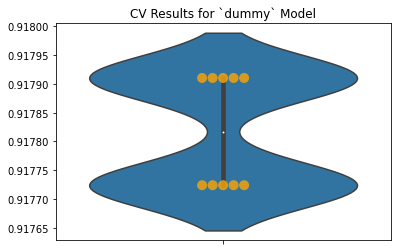

In [227]:
fig,ax = plt.subplots()

dummy_model_pipe.plot_cv(ax=ax)

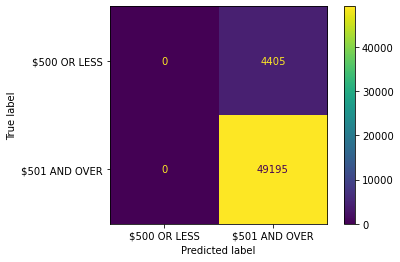

In [228]:
# Plot confusion_matrix:

dummy_model.fit(X_train, y_train)
con_matrix_model1 = plot_confusion_matrix(dummy_model, X_train, y_train)
confusion_matrix_list.append(con_matrix_model1)

In [229]:
# Print 4 scores:

accuracy_score_dict['model1'] = accuracy_score(y_train, y_hat)
recall_score_dict['model1'] = recall_score(y_train, y_hat, pos_label='$501 AND OVER')
precision_score_dict['model1'] = precision_score(y_train, y_hat, pos_label='$501 AND OVER')
# f1_score_dict['model1'] = f1_score(y_train, y_hat, pos_label='$501 AND OVER')

In [231]:
f1_score(y_train, y_hat)

TypeError: 'dict' object is not callable

### Model 2: Create FSM (First Simple Model) - Logistic Regression Model

In [27]:
# Reset solver from 'lbfgs' to 'saga', and max_iter = 300

logreg_fsm = Pipeline([
    ('ct',CT),
    ('logreg_fsm',LogisticRegression(random_state=42, solver='saga', max_iter=300))
])

In [28]:
# Use the class with out logreg pipe

fsm_model_pipe =  ModelWithCV(logreg_fsm, model_name='fsm',X=X_train, y=y_train)

# Getting ConvergenceWarning. Go back to logreg_fsm above to reset the parameters.

C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages

In [29]:
# Score on training data:

logreg_score_train = fsm_model_pipe.print_cv_summary()
logreg_score_train

0.9183776639926757

In [30]:
# Validate with testing data:

logreg_score_test = fsm_model_pipe.print_cv_test_summary()
logreg_score_test

0.9169136227888812

<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

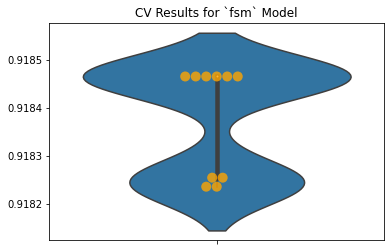

In [31]:
fig,ax = plt.subplots()
fsm_model_pipe.plot_cv(ax=ax)

In [ ]:
# Plot confusion_matrix:

logreg_fsm.fit(X_train, y_train)
con_matrix_model2 = plot_confusion_matrix(dummy_model, X_train, y_train)
confusion_matrix_list.append(con_matrix_model2)

In [ ]:
# Print 4 scores:

accuracy_score_dict['model1'] = accuracy_score(y_train, y_hat)
recall_score_dict['model1'] = recall_score(y_train, y_hat, pos_label='$501 AND OVER')
precision_score_dict['model1'] = precision_score(y_train, y_hat, pos_label='$501 AND OVER')
# f1_score_dict['model1'] = f1_score(y_train, y_hat, pos_label='$501 AND OVER')

### Trying Other Models at the End of the Pipeline
### Model 3: Random Forest

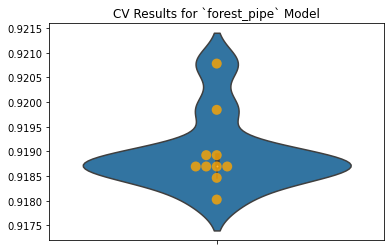

In [32]:
# rfc!
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

forest_pipe.plot_cv(ax=ax);

In [33]:
# Score on training data:

rfc_score_train = forest_pipe.print_cv_summary()
rfc_score_train

0.9189747632988023

In [34]:
# Validate with testing data:

rfc_score_test = forest_pipe.print_cv_test_summary()
rfc_score_test

0.9162935507572435

### Model 4: Gradient Booster

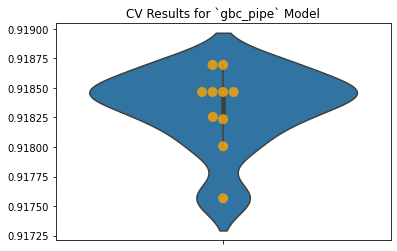

In [52]:
# gbc!
gbc_model_pipe = Pipeline([('ct', CT), ('gbc', GradientBoostingClassifier(random_state=42))])

gbc_pipe = ModelWithCV(model=gbc_model_pipe,
                          model_name='gbc_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

gbc_pipe.plot_cv(ax=ax);

In [53]:
# Score on training data:

gbc_score_train = gbc_pipe.print_cv_summary()
gbc_score_train

0.9183317450414442

In [54]:
# Validate with testing data:

gbc_score_test = gbc_pipe.print_cv_test_summary()
gbc_score_test

0.916500304720028

## Take out column 'ZIPCODE' and re-run the models
It took 1h 32mins to excute Gradient Booster model.
Decided to take out Column 'ZIPCODE' since this dataset is collected in Chicago. Different 'ZIPCODE' might not impact the target much.

Before taking out ‘ZIPCODE’:
- CV Results for `dummy` model:  0.63879 ± 0.00009 accuracy
- CV Results for `forest_pipe` model:  0.62870 ± 0.00595 accuracy
- CV Results for `gbc_pipe` model:  0.63943 ± 0.00072 accuracy


### Model 5: Decision Tree

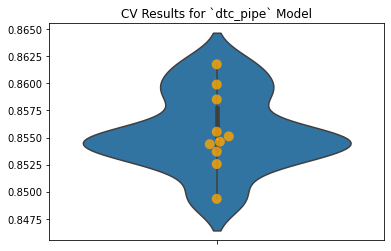

In [35]:
dtc_model_pipe = Pipeline([('ct', CT), ('dtc', DecisionTreeClassifier(random_state=42))])

dtc_pipe = ModelWithCV(model=dtc_model_pipe,
                          model_name='dtc_pipe',
                          X=X_train,
                          y=y_train)

fig, ax = plt.subplots()

dtc_pipe.plot_cv(ax=ax);

In [36]:
# Score on training data:

dtc_score_train = dtc_pipe.print_cv_summary()
dtc_score_train

0.8555416426928639

In [37]:
# Validate with testing data:

dtc_score_test = dtc_pipe.print_cv_test_summary()
dtc_score_test

0.8442310613180233

### Model 6: Tuning and Cross-Validating - Logistic Regression Model

As a result, Logistic Regression Model has the best accuracy. Tune the Logreg Model and perform GridSearch:

In [55]:
# Checking logreg Pipeline:

logreg_fsm

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6EC370EE0>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [56]:
# Set up parameters:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'logreg_fsm__max_iter':[500, 600],
    'logreg_fsm__class_weight':[None, 'balanced']
}

# Set up GridSearchCV and fit training data:
gs_logreg = GridSearchCV(estimator=logreg_fsm, param_grid=params, cv=10, verbose=2)

gs_logreg.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  18.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  18.2s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  18.6s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  18.6s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  18.3s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, tot

[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  11.1s
[CV] ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=mean, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  12.2s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  19.2s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500, total=  19.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logreg_fsm__max_iter=500 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=None, logre

[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  11.6s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  11.9s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  11.0s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600, total=  11.1s
[CV] ct__num_trans__num_impute__strategy=median, logreg_fsm__class_weight=balanced, logreg_fsm__max_iter=600 
[CV]  ct__num_trans__num_impute__strategy=median, logreg_fsm

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 20.2min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6EC370EE0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [57]:
gs_logreg.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'logreg_fsm__class_weight': None,
 'logreg_fsm__max_iter': 500}

In [58]:
tunedLogreg_score_train = gs_logreg.best_score_
tunedLogreg_score_train

0.9183776639926757

In [59]:
# Validate with testing data:
tunedLogreg_score_test = gs_logreg.best_estimator_.score(X_test, y_test)
tunedLogreg_score_test

0.9169135377196004

### Model 7: Tuning and Cross-Validating - Random Forest Model

In [38]:
# Set up parameters:
params = {
    'ct__num_trans__num_impute__strategy':['mean','median'],
    'rfc__criterion':['gini','entropy'],
    'rfc__max_depth':[1,3,5]
}

# Set up GridSearchCV and fit training data:
gs_rfc = GridSearchCV(estimator=rfc_model_pipe, param_grid=params, cv=10, verbose=2)

gs_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   1.8s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   1.6s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   1.6s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   1.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   1.6s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1, total=   1.7s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=gini, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=gi

[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   2.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   2.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   2.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   2.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3 
[CV]  ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=3, total=   2.2s
[CV] ct__num_trans__num_impute__strategy=mean, rfc__criterion=entropy, rfc__max_depth=5 
[CV]  ct__num_trans__num_impute__st

[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=gini, rfc__max_depth=5, total=   3.0s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   1.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   1.7s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1, total=   1.8s
[CV] ct__num_trans__num_impute__strategy=median, rfc__criterion=entropy, rfc__max_depth=1 
[CV]  ct__num_trans__num

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  4.4min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6EC370EE0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [39]:
gs_rfc.best_params_

{'ct__num_trans__num_impute__strategy': 'mean',
 'rfc__criterion': 'gini',
 'rfc__max_depth': 1}

In [40]:
tunedRfc_score_train = gs_rfc.best_score_
tunedRfc_score_train

0.9183776639926757

In [41]:
# Validate with testing data:
tunedRfc_score_test = gs_rfc.best_estimator_.score(X_test, y_test)
tunedRfc_score_test

0.9169135377196004

## Imblearn Pipelines
Dealing with the Target Imbalance, let's use SMOTE.

In [42]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [43]:
# To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

X_train_clean = X_train.select_dtypes('int64').dropna()
y_train_clean = y_train[X_train_clean.index]

In [44]:
y_train_clean

50250    1
33424    1
2012     1
57176    1
7225     1
        ..
54343    1
38158    1
860      1
15795    1
56422    0
Name: DAMAGE, Length: 43542, dtype: int64

In [45]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    39988
0    39988
Name: DAMAGE, dtype: int64

### Model 8-1: ImPipleline with SMOTE (sampling_strategy='auto') and Random Forest Model

In [46]:
# imbpipe!

imb_pipe= ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42)),
    ('rfc',RandomForestClassifier(random_state=42)),
])

imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6EC370EE0>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [47]:
imbRfc_score_train = imb_pipe.score(X_train, y_train)
imbRfc_score_train

0.9999081346745671

In [48]:
# Validate with testing data:
imbRfc_score_test = imb_pipe.score(X_test, y_test)
imbRfc_score_test

0.9038925249741646

### Model 8-2: ImPipleline with SMOTE (sampling_strategy=0.8) and Random Forest Model

In [49]:
imb_pipe80= ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(sampling_strategy=0.8, random_state=42)),
    ('rfc',RandomForestClassifier(random_state=42)),
])

imb_pipe80.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_trans',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6EC370EE0>),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                            

In [50]:
imbRfc80_score_train = imb_pipe.score(X_train, y_train)
imbRfc80_score_train

0.9999081346745671

In [51]:
# Validate with testing data:
imbRfc80_score_test = imb_pipe.score(X_test, y_test)
imbRfc80_score_test

0.9038925249741646

### Model 9: Gridsearching with SMOTE and Random Forest Model

In [60]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__min_samples_leaf': [1, 3],
          'sm__k_neighbors': [3, 5]}

gs_smote_rfc = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=10, verbose=2)

gs_smote_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  15.8s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.7s remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  15.4s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  15.4s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  15.6s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  15.2s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  15.5s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3, total=  15.2s
[CV] rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighbors=3 .
[CV]  rfc__criterion=gini, rfc__min_samples_leaf=1, sm__k_neighb

[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  16.8s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  17.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  17.1s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  17.2s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  16.9s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5 
[CV]  rfc__criterion=entropy, rfc__min_samples_leaf=1, sm__k_neighbors=5, total=  17.0s
[CV] rfc__criterion=entropy, rfc__min_samples_leaf=3, sm__k_neighbors=3 
[CV]  rfc__criterion=entropy, rfc_

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 21.0min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_trans',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6EC370EE0>),
                                                                        ('cat_trans',
                                                                         Pipeline(steps=[('cat_im

In [61]:
gs_smote_rfc.best_params_

{'rfc__criterion': 'entropy', 'rfc__min_samples_leaf': 1, 'sm__k_neighbors': 3}

In [62]:
gsRfc_score_train = gs_smote_rfc.score(X_train, y_train)
gsRfc_score_train

0.9999081346745671

In [63]:
# Validate with testing data:
gsRfc_score_test = gs_smote_rfc.score(X_test, y_test)
gsRfc_score_test

0.904374784705477

## Evaluation and Final Model

### Bring the scores together from all models:

In [64]:
model_list = ['dummy', 'logreg', 'rfc', 'gbc', 'dtc', 'tunedLogreg', 'tunedRfc', 'imbRfc', 'gsRfc']

score_train_list = [] 
score_test_list = []

for i in model_list:
    score_train_list.append(eval(i+'_score_train'))
    score_test_list.append(eval(i+'_score_test'))


In [65]:
df_score_train = pd.DataFrame (score_train_list, columns = ['score_train'], index=model_list)
df_score_test = pd.DataFrame (score_test_list, columns = ['score_test'], index=model_list)
df_score = pd.concat([df_score_train, df_score_test], axis=1)


df_score

,score_train,score_test
dummy,0.918378,0.916914
logreg,0.918378,0.916914
rfc,0.918975,0.916294
gbc,0.918332,0.916500
dtc,0.855542,0.844231
tunedLogreg,0.918378,0.916914
tunedRfc,0.918378,0.916914
imbRfc,0.999908,0.903893
gsRfc,0.999908,0.904375


In [66]:
df_score['difference'] = df_score['score_test']-df_score['score_train']
df_score

,score_train,score_test,difference
dummy,0.918378,0.916914,-0.001464
logreg,0.918378,0.916914,-0.001464
rfc,0.918975,0.916294,-0.002681
gbc,0.918332,0.916500,-0.001831
dtc,0.855542,0.844231,-0.011311
tunedLogreg,0.918378,0.916914,-0.001464
tunedRfc,0.918378,0.916914,-0.001464
imbRfc,0.999908,0.903893,-0.096016
gsRfc,0.999908,0.904375,-0.095533


### Score DataFrame:

In [67]:
df_score['fitting'] = np.where(df_score['difference'] < 0, "over fitting", "under fitting")
df_score

,score_train,score_test,difference,fitting
dummy,0.918378,0.916914,-0.001464,over fitting
logreg,0.918378,0.916914,-0.001464,over fitting
rfc,0.918975,0.916294,-0.002681,over fitting
gbc,0.918332,0.916500,-0.001831,over fitting
dtc,0.855542,0.844231,-0.011311,over fitting
tunedLogreg,0.918378,0.916914,-0.001464,over fitting
tunedRfc,0.918378,0.916914,-0.001464,over fitting
imbRfc,0.999908,0.903893,-0.096016,over fitting
gsRfc,0.999908,0.904375,-0.095533,over fitting


## Final Model!

In [99]:
final_model = gs_smote_rfc

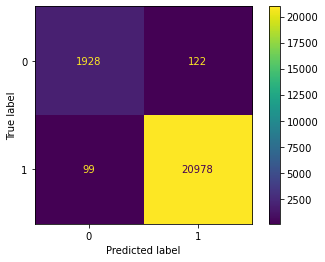

In [100]:
plot_confusion_matrix(final_model, X_train, y_train);

In [111]:
y_hat = final_model.predict(X_train)

In [112]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_train, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_train, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_train, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_train, y_hat), 2)}.
""")

C:\Users\Chiafeng\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:


ValueError: pos_label=1 is not a valid label: array(['0', '1'], dtype='<U1')

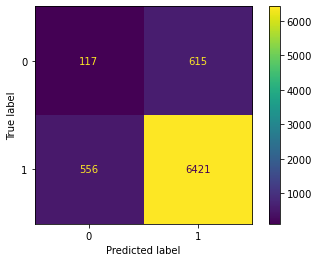

In [113]:
plot_confusion_matrix(final_model, X_test, y_test);

In [ ]:
y_hat = final_model.predict(X_test)